# Solving Characteristic equation of TE Modes

In [1]:
%matplotlib inline
import warnings
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import numpy as np
from scipy.special import jv, kv, jn_zeros
from scipy.optimize import fsolve

## TM mode equation

$$
\left(\frac{n_1}{n_2}\right)^2\frac{w\,J_1(u)}{J_0(u)} + \frac{u\,K_1(w)}{K_0} = 0
$$

풀어야 할 TM 모드 방정식을 함수 형태로 정리한다.  
TE, TM 모드는 그렇지 않지만 다른 general mode는 특성방정식에 여러 Bessel integer가 가능하다.  
이것에 일반적으로 대응되는 코드 형식을 유지하기 위해 클로저 형태로 함수를 정의했다.


In [2]:
def gen_eigen_eq(n1, n2, **kwargs):
    
    def eq_tm(u):
        w = np.sqrt(v*v - u*u)
        return (n1/n2)**2 * w * jv(1, u) / jv(0, u) + u * kv(1, w) / kv(0, w)

    if kwargs.get("mode")=="TM":
        return eq_tm

다음과 같이 TE eigen eq.를 LHS와 RHS로 나누어 정리해 두면 Graphical solution을 구하기 위해 그래프를 그리고 해를 분석하기 편리하다.

## Graphical Soulution of TM mode

Graphical solution을 구하기 위해 `scipy.optimize`모듈의 함수 `fsolve()`를 사용한다.  
이때의 주요 문제는 다양한 V 값에 대해 모든 해를 오류없이 구하기 위한 '초기값' 설정이다.  
이 초기값만 잘 설정해 줄 수 있으면 `fsolve()`함수로 무리없이 방정식의 근을 구할 수 있다.

### Getting asymtotic points

올바른 해를 얻기 위한 수치계산 초기값 설정에는 eigenvalue equation이 발산하는 지점을 아는 것이 중요하다.  
이 발산점들을 향해 eigenvalue eq.는 점근(asymtote)한다.  
다음에 주어진 V 값에 대한 방정식의 모든 점근선 위치를 반환하는 함수를 정의한다.  

먼저 주어진 V 값에 대해 몇 개의 발산 포인트가 있는지 계산해주는 함수를 만들고,

In [3]:
def num_of_zeros_jn(v, l) -> int:
  count: int = 1
  while jn_zeros(l, count)[-1] < v:
    count += 1
    if count > 100:
      raise ValueError("Too many points of Bessel zeros")
  num = count - 1 
  return num

이를 이용해 asymtotic_point를 구하는 함수를 다음과 같이 정의할 수 있다.

In [6]:
def get_asymtotic_points(v, l) -> list:
  num: int = num_of_zeros_jn(v, l)
  if num ==0:
    return None
  else:
    asymtotic_points = jn_zeros(l, num)
    return asymtotic_points

### Define plotting funtion to analysis

다음과 같이 eigenvalue equation 전체를 plot하는 함수를 정의하여 분석에 이용한다. 

In [7]:
def plot_eigen_eq(v, n1, n2):
  fig, axe = plt.subplots()

  delta = 0.00001
  u = np.linspace(delta, v-delta, int(v*5000))
  eigen = gen_eigen_eq(n1, n2, mode='TM')
  eq = eigen(u)

  label = f"$(n1/n2)^2w J_1(u)/J_0(u)+u K_1(u)/K_0(u)$"

  # Limits plot range by setting values over 1.2V as 'None'
  plot_limit = 50
  meq = np.where(abs(eq) >= plot_limit, None, eq)

  axe.set_title(r"$TE_{0m}$ modes"+f" @V={v:.4f}")
  axe.plot(u, meq, color='green', label=label) # plot eigen-value eq.
  axe.hlines(y=0, xmin=0, xmax=v, colors='k') # plot x axis.
  axe.set_xlabel("$u$")
  axe.set_ylim(-plot_limit, plot_limit)
  axe.xaxis.set_minor_locator(AutoMinorLocator(5))
  axe.legend(loc=2)

  # plot diverging assymtotic lines
  asymtotic_lines = get_asymtotic_points(v, l=0)
  print(f"asymtotic_lines={asymtotic_lines}")
  plt.vlines(x=asymtotic_lines, ymin=-plot_limit, ymax=plot_limit, linestyles='dashed', colors='k', alpha=0.5, linewidth=0.9)

  return axe

asymtotic_lines=[2.40482556 5.52007811 8.65372791]


<Axes: title={'center': '$TE_{0m}$ modes @V=10.0000'}, xlabel='$u$'>

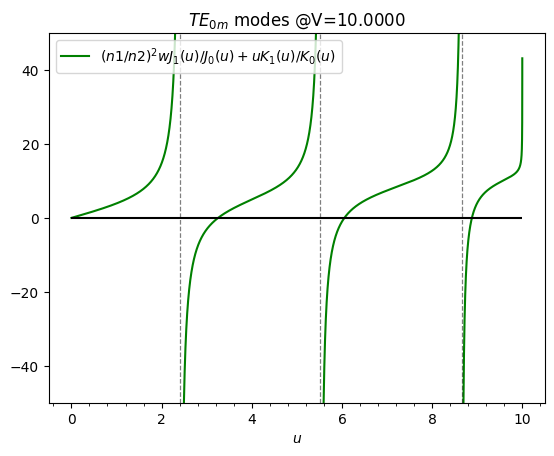

In [8]:
v = 10
n2 = 1.444
na = 0.22
n1 = (na/n2)**2 + 1
plot_eigen_eq(v, n1, n2)

### Initial values to get numerical solutions

그래프를 그려가며 분석한 결과 V 값이 방정식의 점근선에 가까울 때 마지막 근의 경우  
그래프가 급격히 변화하여 `RuntimeWarning`이 발생한다.  
이와 같은 경우는 다음과 같이 마지막 초기값을 점근선과 V값의 중앙 값으로 하여 해결할 수 있다.

In [15]:
def get_init_points_to_solve(v):
  asymtotic_points = get_asymtotic_points(v, 0)
  if asymtotic_points is not None:
    offset = (v - asymtotic_points[-1])/2 # critical to avoide RuntimeWarning
    init_points = asymtotic_points + offset
    return init_points
  else:
    return None

### Function to get list of solutions

위의 함수로 수치해를 풀 초기값을 설정한 후 다음 함수로 해집합을 에러 없이 구할 수 있다.

In [16]:
def get_roots(v, n1, n2):
  init_points = get_init_points_to_solve(v)
  eigen_equation = gen_eigen_eq(n1, n2, mode='TM')

  if init_points is not None:
    with warnings.catch_warnings():
      warnings.simplefilter("error", RuntimeWarning)

      try:
        roots = fsolve(eigen_equation, init_points)
      except RuntimeWarning as e:
        print(f"\nRuntimeWarning: {e}")
        near_v = (v + get_asymtotic_points(v, 0)[-1])/2
        if len(init_points) == 1:
          roots[-1] = near_v
        else:
          roots = fsolve(eigen_equation, init_points[:-1])
          roots = np.append(roots, near_v)
        print("The last solution is replaced by the near value V.\n")
      finally:
        return roots
  else:
    return None

V = 11.791544439014281
Roots =[ 3.31978761  6.15392008  9.02412538 11.79154283]
asymtotic_lines=[ 2.40482556  5.52007811  8.65372791 11.79153444]


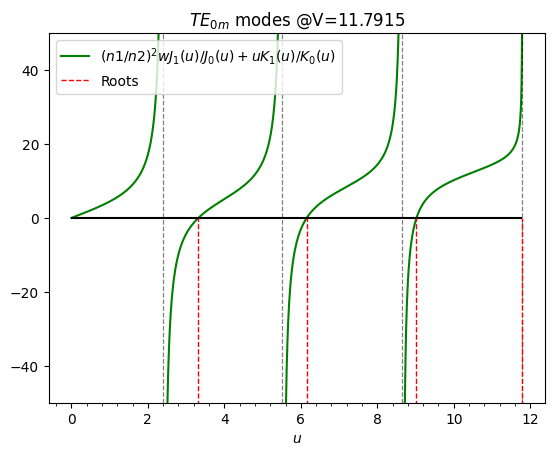

In [19]:
v = jn_zeros(0, 4)[-1] + 0.00001
print(f"V = {v}")
na = 0.22
n2 = 1.444
n1 = (na/n2)**2 + 1

roots = get_roots(v, n1, n2)
print(f"Roots ={roots}")

axe = plot_eigen_eq(v, n1, n2)
axe.vlines(x=roots, ymin=-70, ymax=0, linestyles='dashed', colors='r', linewidth=1.0, label="Roots")
axe.legend(loc=2)